<a href="https://colab.research.google.com/github/abhinavsagar/Breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading & Preprocessing

In [90]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
import json
import itertools


%matplotlib inline

In [91]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader(r'C:\Users\ravi kumar\Downloads\breast-cancer-classification-new\breast-cancer-classification-master\train\begin', 224))
malign_train = np.array(Dataset_loader(r'C:\Users\ravi kumar\Downloads\breast-cancer-classification-new\breast-cancer-classification-master\train\malign', 224))
benign_test = np.array(Dataset_loader(r'C:\Users\ravi kumar\Downloads\breast-cancer-classification-new\breast-cancer-classification-master\test\begin', 224))
malign_test = np.array(Dataset_loader(r'C:\Users\ravi kumar\Downloads\breast-cancer-classification-new\breast-cancer-classification-master\test\malign', 224))

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 613.38it/s]


# Create Label

In [92]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [93]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

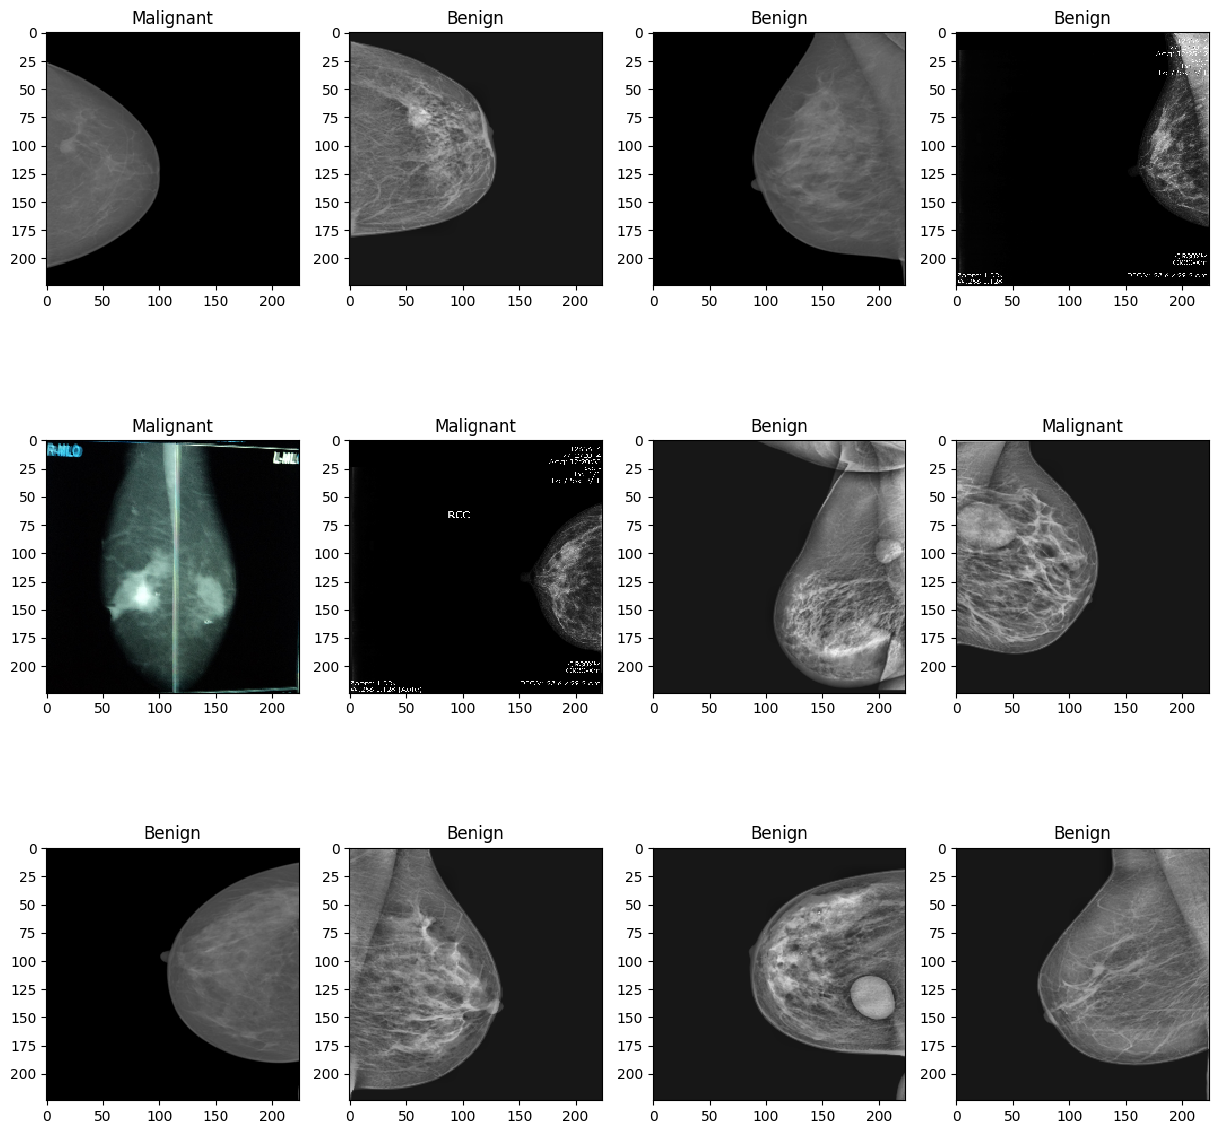

In [94]:

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [95]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,
    )

# Model: DenseNet201

In [97]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [98]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [99]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [100]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)
model.save('model.h5')

Epoch 1/60


C:\Users\ravi kumar\AppData\Local\Temp\ipykernel_14264\3308437402.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


13/12 [==============================] - ETA: -2s - loss: 0.6639 - accuracy: 0.6324
Epoch 1: val_accuracy improved from -inf to 0.82692, saving model to weights.best.hdf5
12/12 [==============================] - 168s 12s/step - loss: 0.6639 - accuracy: 0.6324 - val_loss: 0.5519 - val_accuracy: 0.8269 - lr: 1.0000e-04
Epoch 2/60
13/12 [==============================] - ETA: -2s - loss: 0.5668 - accuracy: 0.7549
Epoch 2: val_accuracy improved from 0.82692 to 0.84615, saving model to weights.best.hdf5
12/12 [==============================] - 131s 10s/step - loss: 0.5668 - accuracy: 0.7549 - val_loss: 0.4749 - val_accuracy: 0.8462 - lr: 1.0000e-04
Epoch 3/60
13/12 [==============================] - ETA: -2s - loss: 0.5124 - accuracy: 0.7500
Epoch 3: val_accuracy improved from 0.84615 to 0.86538, saving model to weights.best.hdf5
12/12 [==============================] - 130s 10s/step - loss: 0.5124 - accuracy: 0.7500 - val_loss: 0.4741 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 4/60
13/1

In [51]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [56]:
model.load_weights("weights.best.hdf5")

In [57]:
Y_val_pred = model.predict(x_val)

2/2 [==============================] - 6s 2s/step


In [60]:
accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
print(accuracy)

0.9230769230769231


In [61]:
Y_pred = model.predict(X_test)


2/2 [==============================] - 4s 521ms/step


In [35]:
# Convert the file to an opencv image.
image = r'C:\Users\ravi kumar\Downloads\breast-cancer-classification-new\breast-cancer-classification-master\test\malign\Malign12.jpg'

opencv_image =cv2.imread(image)
# Displaying the image
#Resizing the image
opencv_image = cv2.resize(opencv_image, (224,224))
#Convert image to 4 Dimension
opencv_image.shape = (1,224,224,3)

pred = model.predict(opencv_image)
print(pred)
print(np.argmax(pred))

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

### Confusion Matrix

Confusion matrix, without normalization
[[13  3]
 [ 4 16]]


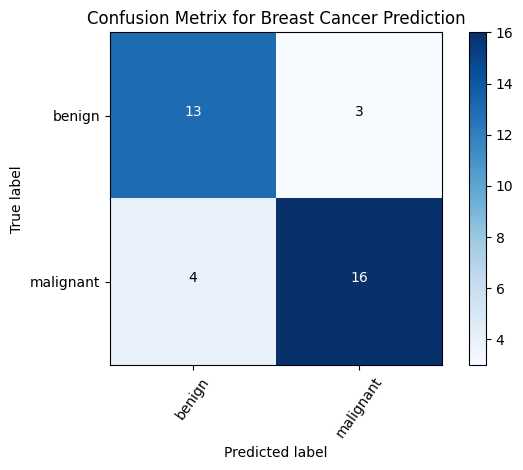

In [63]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer Prediction')

Confusion matrix, without normalization
[[16  0]
 [10 10]]


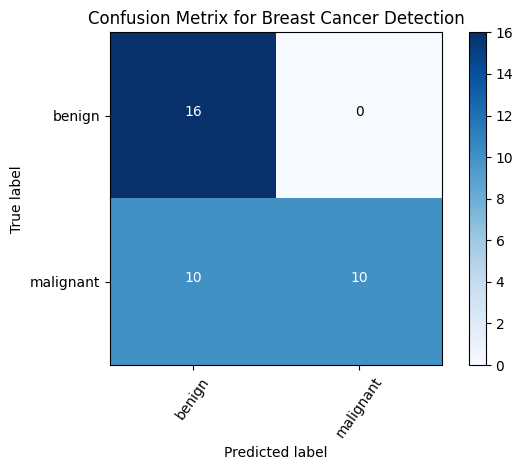

In [64]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer Detection')

### Classification Report

In [70]:
from sklearn.metrics import classification_report
report = classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.84      0.80      0.82        20

    accuracy                           0.81        36
   macro avg       0.80      0.81      0.80        36
weighted avg       0.81      0.81      0.81        36



### ROC and AUC

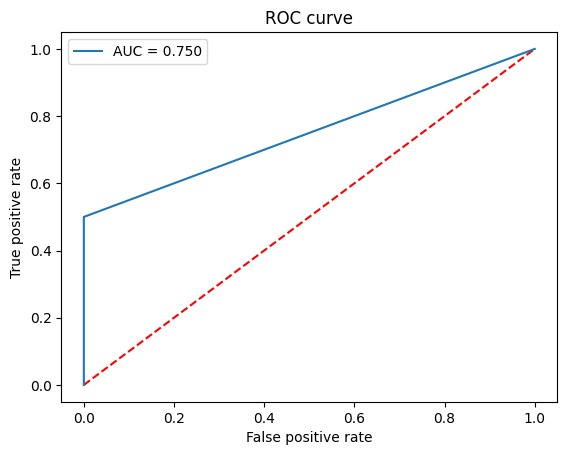

In [71]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

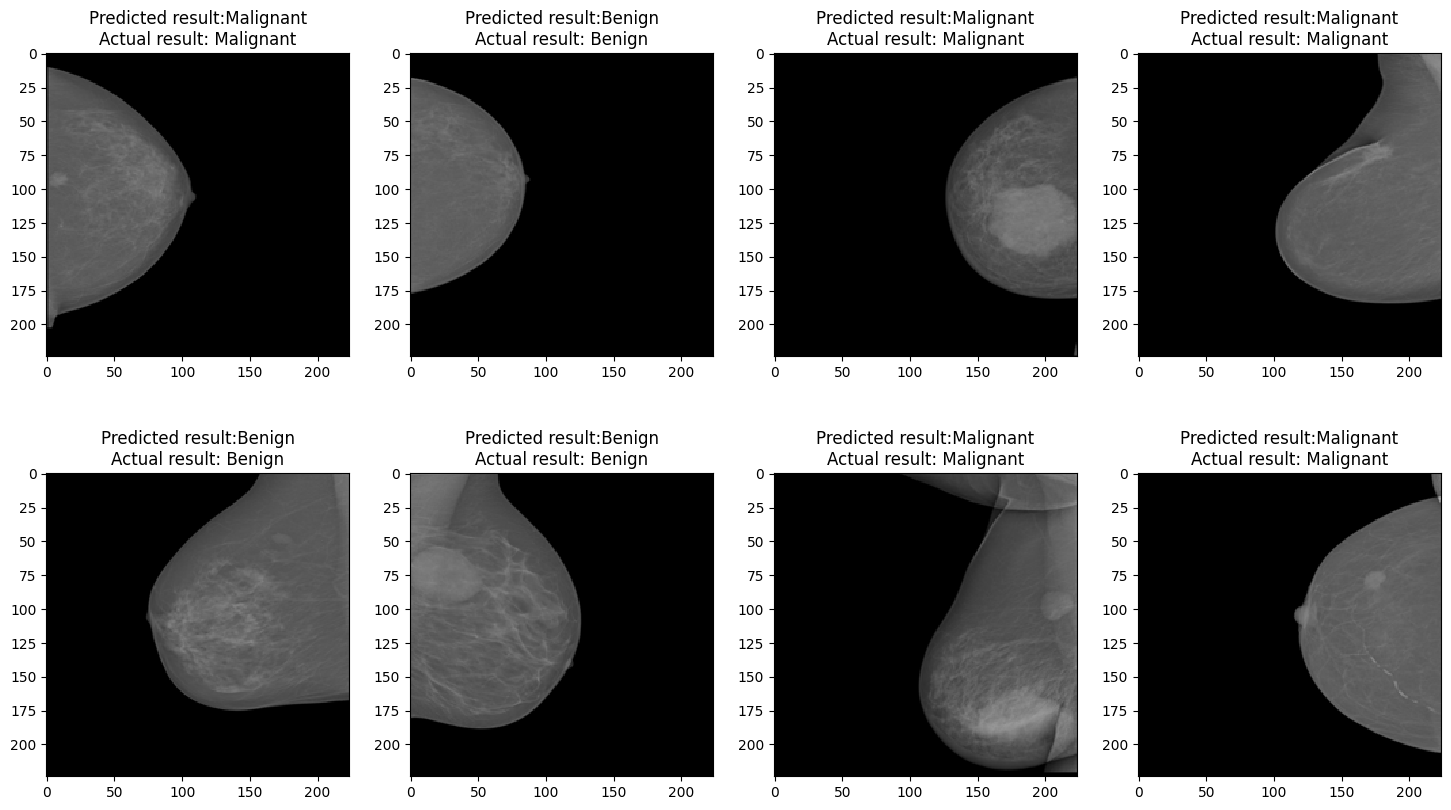

In [72]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()